In [1]:
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from survival_analysis import prepare_df
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = prepare_df()

In [15]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


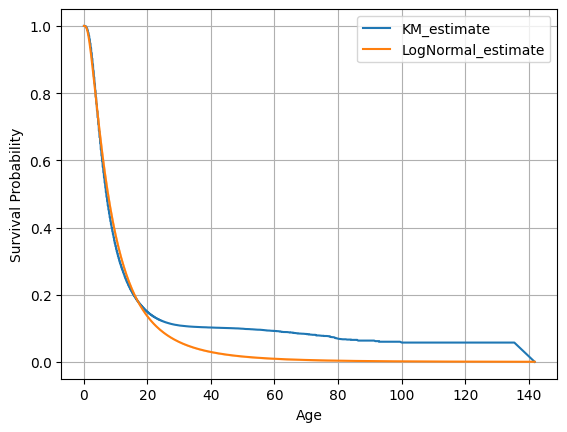

In [5]:
ages, dead = df_analysis['dead_age'], df_analysis['Dead']

kmf = KaplanMeierFitter()
kmf.fit(ages, dead)
ln = LogNormalFitter()
ln.fit(ages, dead)

# Plot the survival function
kmf.survival_function_.plot()
ln.plot_survival_function()
plt.xlabel("Age")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

In [ ]:
models = {
    'Weibull': WeibullFitter(),
    'Exponential': ExponentialFitter(),
    'LogNormal': LogNormalFitter(),
    'LogLogistic': LogLogisticFitter()
}

results = {}

for name, model in models.items():
    model.fit(ages, event_observed=dead)
    results[name] = {
        'model': model,
        'AIC': model.AIC_,
        'Log-Likelihood': model.log_likelihood_
    }

summary = pd.DataFrame(results).T.sort_values('AIC')
print(summary.sort_values('AIC'))

                                                         model  \
LogNormal    <lifelines.LogNormalFitter:"LogNormal_estimate...   
LogLogistic  <lifelines.LogLogisticFitter:"LogLogistic_esti...   
Weibull      <lifelines.WeibullFitter:"Weibull_estimate", f...   
Exponential  <lifelines.ExponentialFitter:"Exponential_esti...   

                        AIC  Log-Likelihood  
LogNormal    7085198.683392 -3542597.341696  
LogLogistic  7096680.507778 -3548338.253889  
Weibull      7256114.031868 -3628055.015934  
Exponential  7460041.922745 -3730019.961373  


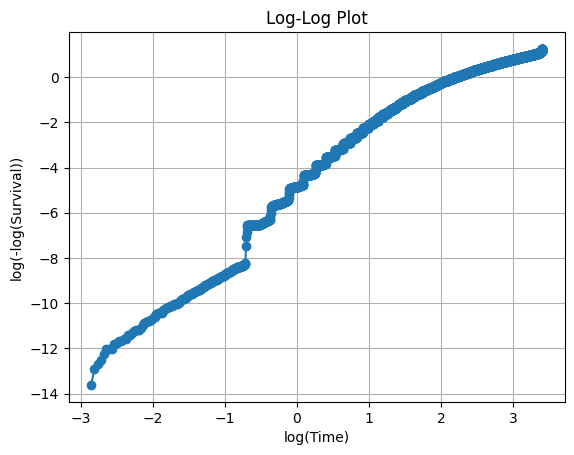

In [ ]:
# Compute log(-log(S)) and log(t)
t = kmf.survival_function_.index.values
S = kmf.survival_function_['KM_estimate'].values

log_t = np.log(t[1:])  # skip t = 0
log_minus_log_S = np.log(-np.log(S[1:]))

fig, ax = plt.subplots()
plt.plot(log_t, log_minus_log_S, marker='o')
plt.xlabel('log(Time)')
plt.ylabel('log(-log(Survival))')
plt.title('Log-Log Plot')
plt.grid(True)
plt.show()

<Figure size 800x500 with 0 Axes>

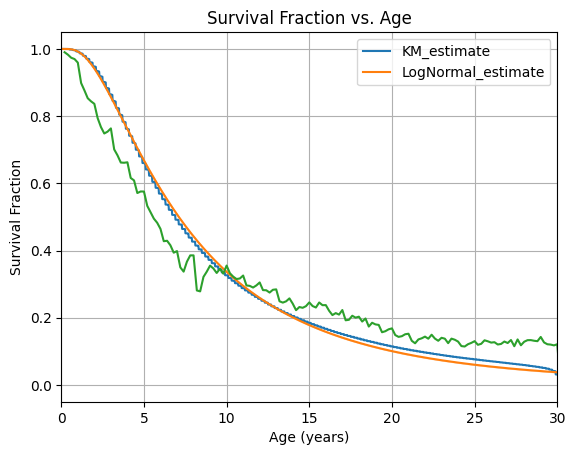

In [ ]:
# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)

# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
kmf.survival_function_.plot()
ln.plot_survival_function()
sns.lineplot(x=surv_frac['age_bin'].apply(lambda x: x.right),
             y=surv_frac['status'])
plt.xlim(0,30)
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.title('Survival Fraction vs. Age')
plt.grid(True)
plt.show()

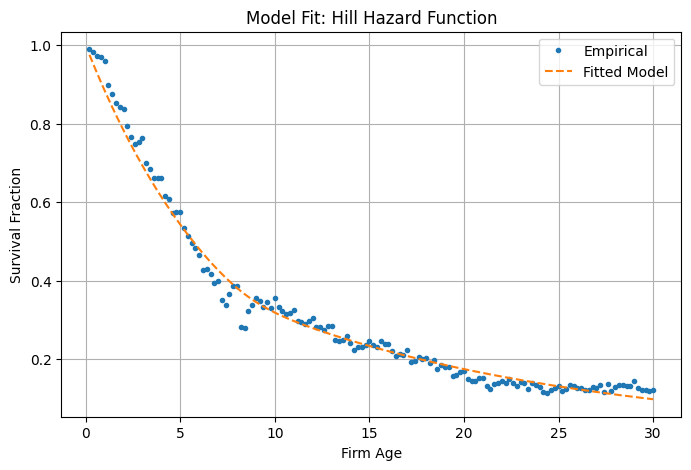

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

# ---- Step 1: Define the Hill-type hazard function ----

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve(ages, mu_ub, mu_lb, K, m):
    return np.array([survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# ---- Step 4: Objective function to minimize squared error between model and empirical ----

def objective(params, ages, observed_survival):
    mu_ub, mu_lb, K, m = params
    if mu_ub < mu_lb or mu_ub < 0 or mu_lb < 0:
        return np.inf
    predicted = model_survival_curve(ages, mu_ub, mu_lb, K, m)
    return np.sum((predicted - observed_survival)**2)

# ---- Step 5: Fit parameters ----

def fit_survival_model(ages, survival_fractions):
    initial_guess = [0.3, 0.01, 5, 2]  # mu_ub, mu_lb, K, m
    bounds = [(0.001, 1), (0.0001, 1), (0.1, 20), (0.5, 10)]
    result = minimize(objective, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# ---- Step 6: Example usage with your data ----

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)


# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()
surv_frac = surv_frac.loc[~(surv_frac == 0).any(axis=1)]
survival_fractions = np.array(surv_frac['status'])
ages = surv_frac['age_bin'].apply(lambda x: x.right)

result = fit_survival_model(ages, survival_fractions)
best_params = result.x
predicted_curve = model_survival_curve(ages, *best_params)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
plt.plot(ages, predicted_curve, '--', label="Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title("Model Fit: Hill Hazard Function")
plt.grid(True)
plt.legend()
plt.show()

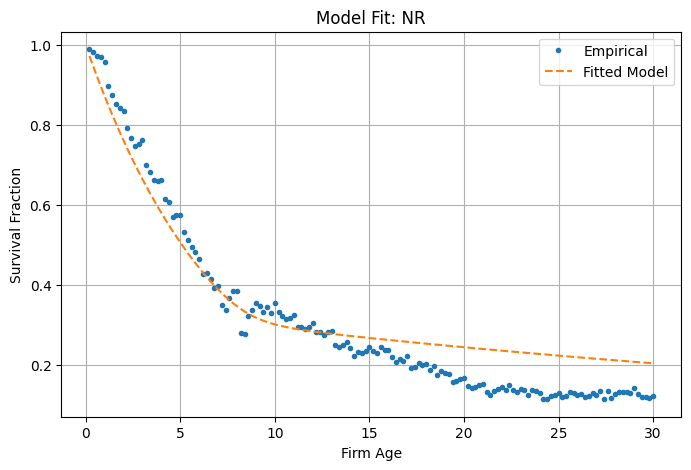

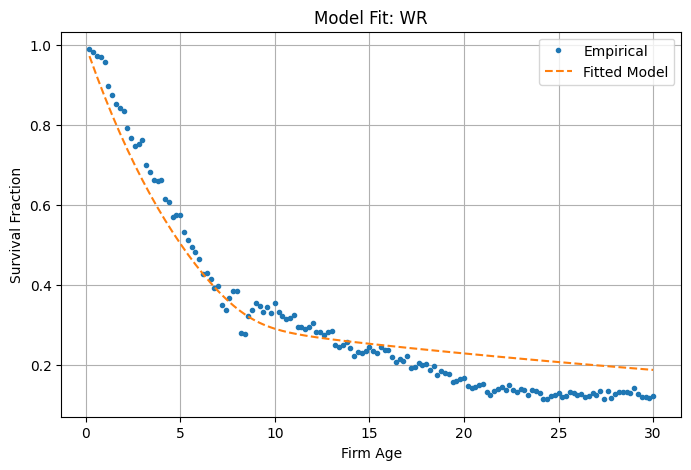

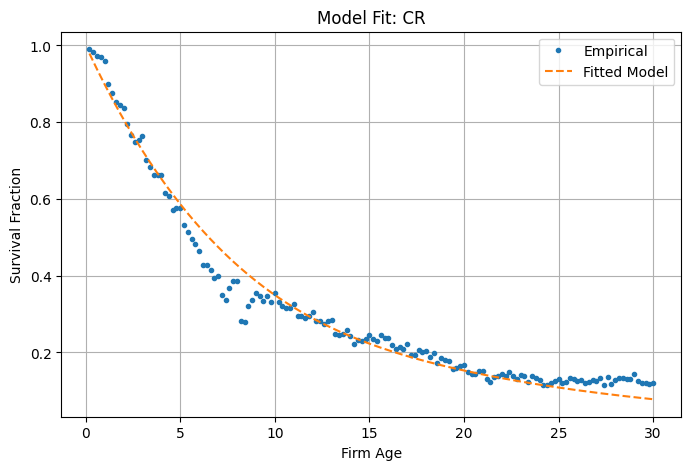

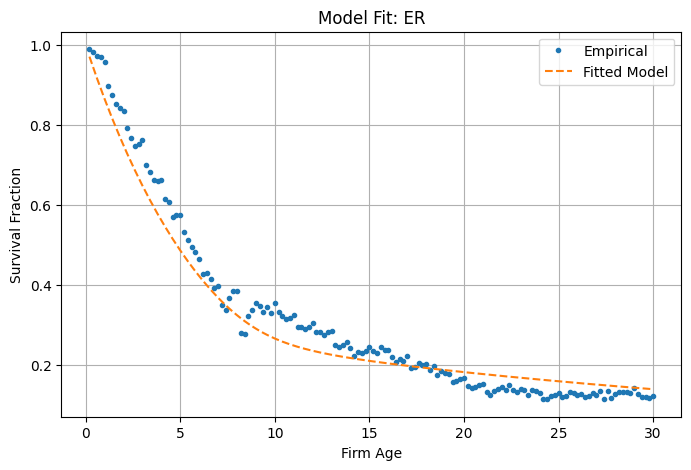

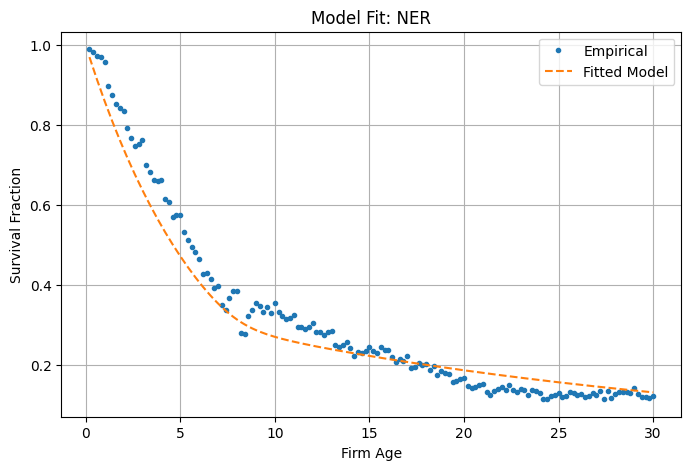

In [20]:
from survival_analysis import obtain_survival_fractions
region_list = ['NR','WR','CR','ER','NER']

for region in region_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', region)
    result = fit_survival_model(ages, survival_frac)
    best_params = result.x
    predicted_curve = model_survival_curve(ages, *best_params)

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit: {region}")
    plt.grid(True)
    plt.legend()
    plt.show()